# Mutation rate analysis

## Background

We want to distinguish between two mutational models for GCs:
1. The mutation process is continuous during DZ proliferation.
2. The mutation process is punctuated, acting only at the last cell division.

This question is closely analogous to the classical [Luria–Delbrück](https://en.wikipedia.org/wiki/Luria–Delbrück_experiment) calculation (1969 Nobel prize).

### Model 2: Last-cycle mutation

Let $n_i$ denote the number of cells in the $i$–th burst (out of $N$), let $p$ denote the probability of a last-cycle mutation, and let r.v. $m_i$ denote the number of mutated cells in the $i$–th burst.
Then
$$
m_i \sim \text{Binomial}(n_i, p), \quad i = 1, 2, \ldots, N.
$$

### Model 1: Continuous mutation process

If mutations can be inherited, the distribution of $m_i$ is more complicated and overdispersed.
Following Luria and Delbrück, we will use a two-type Yule process to model the distribution of $m_i$.
Fix birth rate $\lambda=1$ and mutation rate $\mu = 2p$ from type 1 to type 2, and run until population size $n_i$.
Then
$$
m_i \sim \dots
$$


In [235]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import multiprocessing as mp
import concurrent.futures
import bdms

In [2]:
df = pd.read_excel("240402Burst_summary_wDZdensity.xlsx", index_col=0).iloc[:, :12]

df = df.loc[df["# total GC seq"] >= df["# in bursting node"] + df["# desc of bursting node"]]
df = df.loc[df["Fig 1. ID"].isna() == False, :]
df = df.astype({"Fig 1. ID": int, "# total GC seq": int, "# in bursting node": int, "# desc of bursting node": int})

df["# total in burst"] = df["# in bursting node"] + df["# desc of bursting node"]
df["population size"] = df["Norm burst"] + df["Norm  desc"]
df["parental fraction"] = df["# in bursting node"] / df["# total in burst"]

df.to_csv("output/data.csv")

df

,Fig 1. ID,# in bursting node,# desc of bursting node,# total GC seq,BB density,BB(DZ) density,NDS,Normalization factor,Norm burst,Norm desc,Unnamed: 11,# divisions,# total in burst,population size,parental fraction
ID,,,,,,,,,,,,,,,
C_GC3_2,1,31,42,78,0.748,1.006586,NaN,25.809893,800.106672,1084.015491,42.465753,9.644049,73,1884.122163,0.424658
C_GC5_3,2,15,15,44,0.656,0.907424,NaN,41.246534,618.698012,618.698012,50.000000,9.273092,30,1237.396024,0.500000
M8-5.2:3_1 RY,4,13,55,89,0.610,0.920926,NaN,20.694972,269.034632,1138.223444,19.117647,8.071648,68,1407.258076,0.191176
M8-4.1:2_1 Y,3,17,49,90,0.661,0.797423,NaN,17.720517,301.248796,868.305352,25.757576,8.234812,66,1169.554148,0.257576
M9-6.1:4_1 R,5,13,40,82,0.473,0.950910,NaN,23.192924,301.508013,927.716963,24.528302,8.236053,53,1229.224975,0.245283


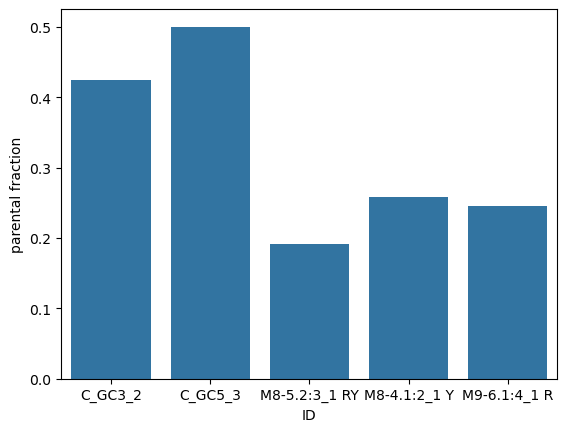

In [3]:
sns.barplot(data=df, x=df.index, y="parental fraction")
plt.show()

## Simulation

In [4]:
birth_rate = 1.0
stop_death_rate = 100. * birth_rate
stop_freq = .048

types = [0, 1, 2]

P = np.array([
    [0, 1 - stop_freq, stop_freq],
    [0, 1 - stop_freq, stop_freq],
    [0, 0, 1]
])

birth_process = bdms.poisson.ConstantProcess(birth_rate)
death_process = bdms.poisson.DiscreteProcess([0, 0, stop_death_rate])
mutation_process = bdms.poisson.ConstantProcess(0.0)
mutator = bdms.mutators.DiscreteMutator(types, P)

n_attempts = 20

viz_kwargs = dict(
    color_map={0: "lightgrey", 1: "black", 2: "red"},
    units="in",
    h=2,
    mode="c",
    scale=10,
)

In [5]:
def null_sim(mutation_prob, N, n, rng, render=False):
    tree = bdms.Tree(state=0)
    for attempt in range(n_attempts):
        try:
            tree.evolve(
                np.inf,
                birth_process=birth_process,
                death_process=death_process,
                mutation_process=mutation_process,
                mutator=mutator,
                birth_mutation_prob=mutation_prob,
                capacity=N,
                capacity_method="stop",
                min_survivors=N,
                seed=rng,
            )
            break
        except bdms.tree.TreeError as e:
            if attempt == n_attempts - 1:
                raise e
            else:
                print(f"  TreeError, retry {attempt + 1}\n", flush=True)
                continue

    tree.sample_survivors(n=n, seed=rng)
    tree.prune_unsampled()

    if render:
        display(tree.render("%%inline", **viz_kwargs))

    type_counts = Counter(leaf.state for leaf in tree)
    type_counts_total = type_counts.total()
    assert type_counts_total == n

    return type_counts[0], type_counts[1] + type_counts[2], type_counts[0] / type_counts_total
    

In [26]:
rng = np.random.default_rng(seed=0)

mutation_probs = np.geomspace(1/30, 1/3, 10)
n_sims = [int(n_sim) for n_sim in np.geomspace(1000, 10000, 10)]

sim_df = []
for gc in df.index:
    print(f"{gc}")
    for mutation_prob, n_sim in zip(mutation_probs, n_sims):
        print(f"  {mutation_prob=:.3f}, {n_sim=}", flush=True)
        N = df.loc[gc, "population size"]
        n = df.loc[gc, "# total in burst"]
        def f(rng_):
            return [mutation_prob, gc, *null_sim(mutation_prob, N, n, rng_)]
        with concurrent.futures.ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
            sim_df.extend(
                executor.map(
                    f, rng.spawn(n_sim)
                )
            )

        # p = (sim_df["parental fraction"] >= n_parental_true / n).mean()
        # if p == 0:
        #     p = 1 / n_sim
        #     p_rel = "<"
        # else:
        #     p_rel = "="

        # print(f"  n_parental_sim_mean={sim_df['parental fraction'].mean():.2f}, p{p_rel}{p:.1e}", flush=True)

sim_df = pd.DataFrame(sim_df, columns=["mutation_prob", "GC", "n_parental", "n_mutated", "parental_fraction"])

sim_df

,mutation_prob,GC,n_parental,n_mutated,parental_fraction
0,0.033333,C_GC3_2,52,21,0.712329
1,0.033333,C_GC3_2,39,34,0.534247
2,0.033333,C_GC3_2,38,35,0.520548
3,0.033333,C_GC3_2,62,11,0.849315
4,0.033333,C_GC3_2,51,22,0.698630
...,...,...,...,...,...
204320,0.333333,M9-6.1:4_1 R,1,52,0.018868
204321,0.333333,M9-6.1:4_1 R,2,51,0.037736
204322,0.333333,M9-6.1:4_1 R,1,52,0.018868
204323,0.333333,M9-6.1:4_1 R,0,53,0.000000


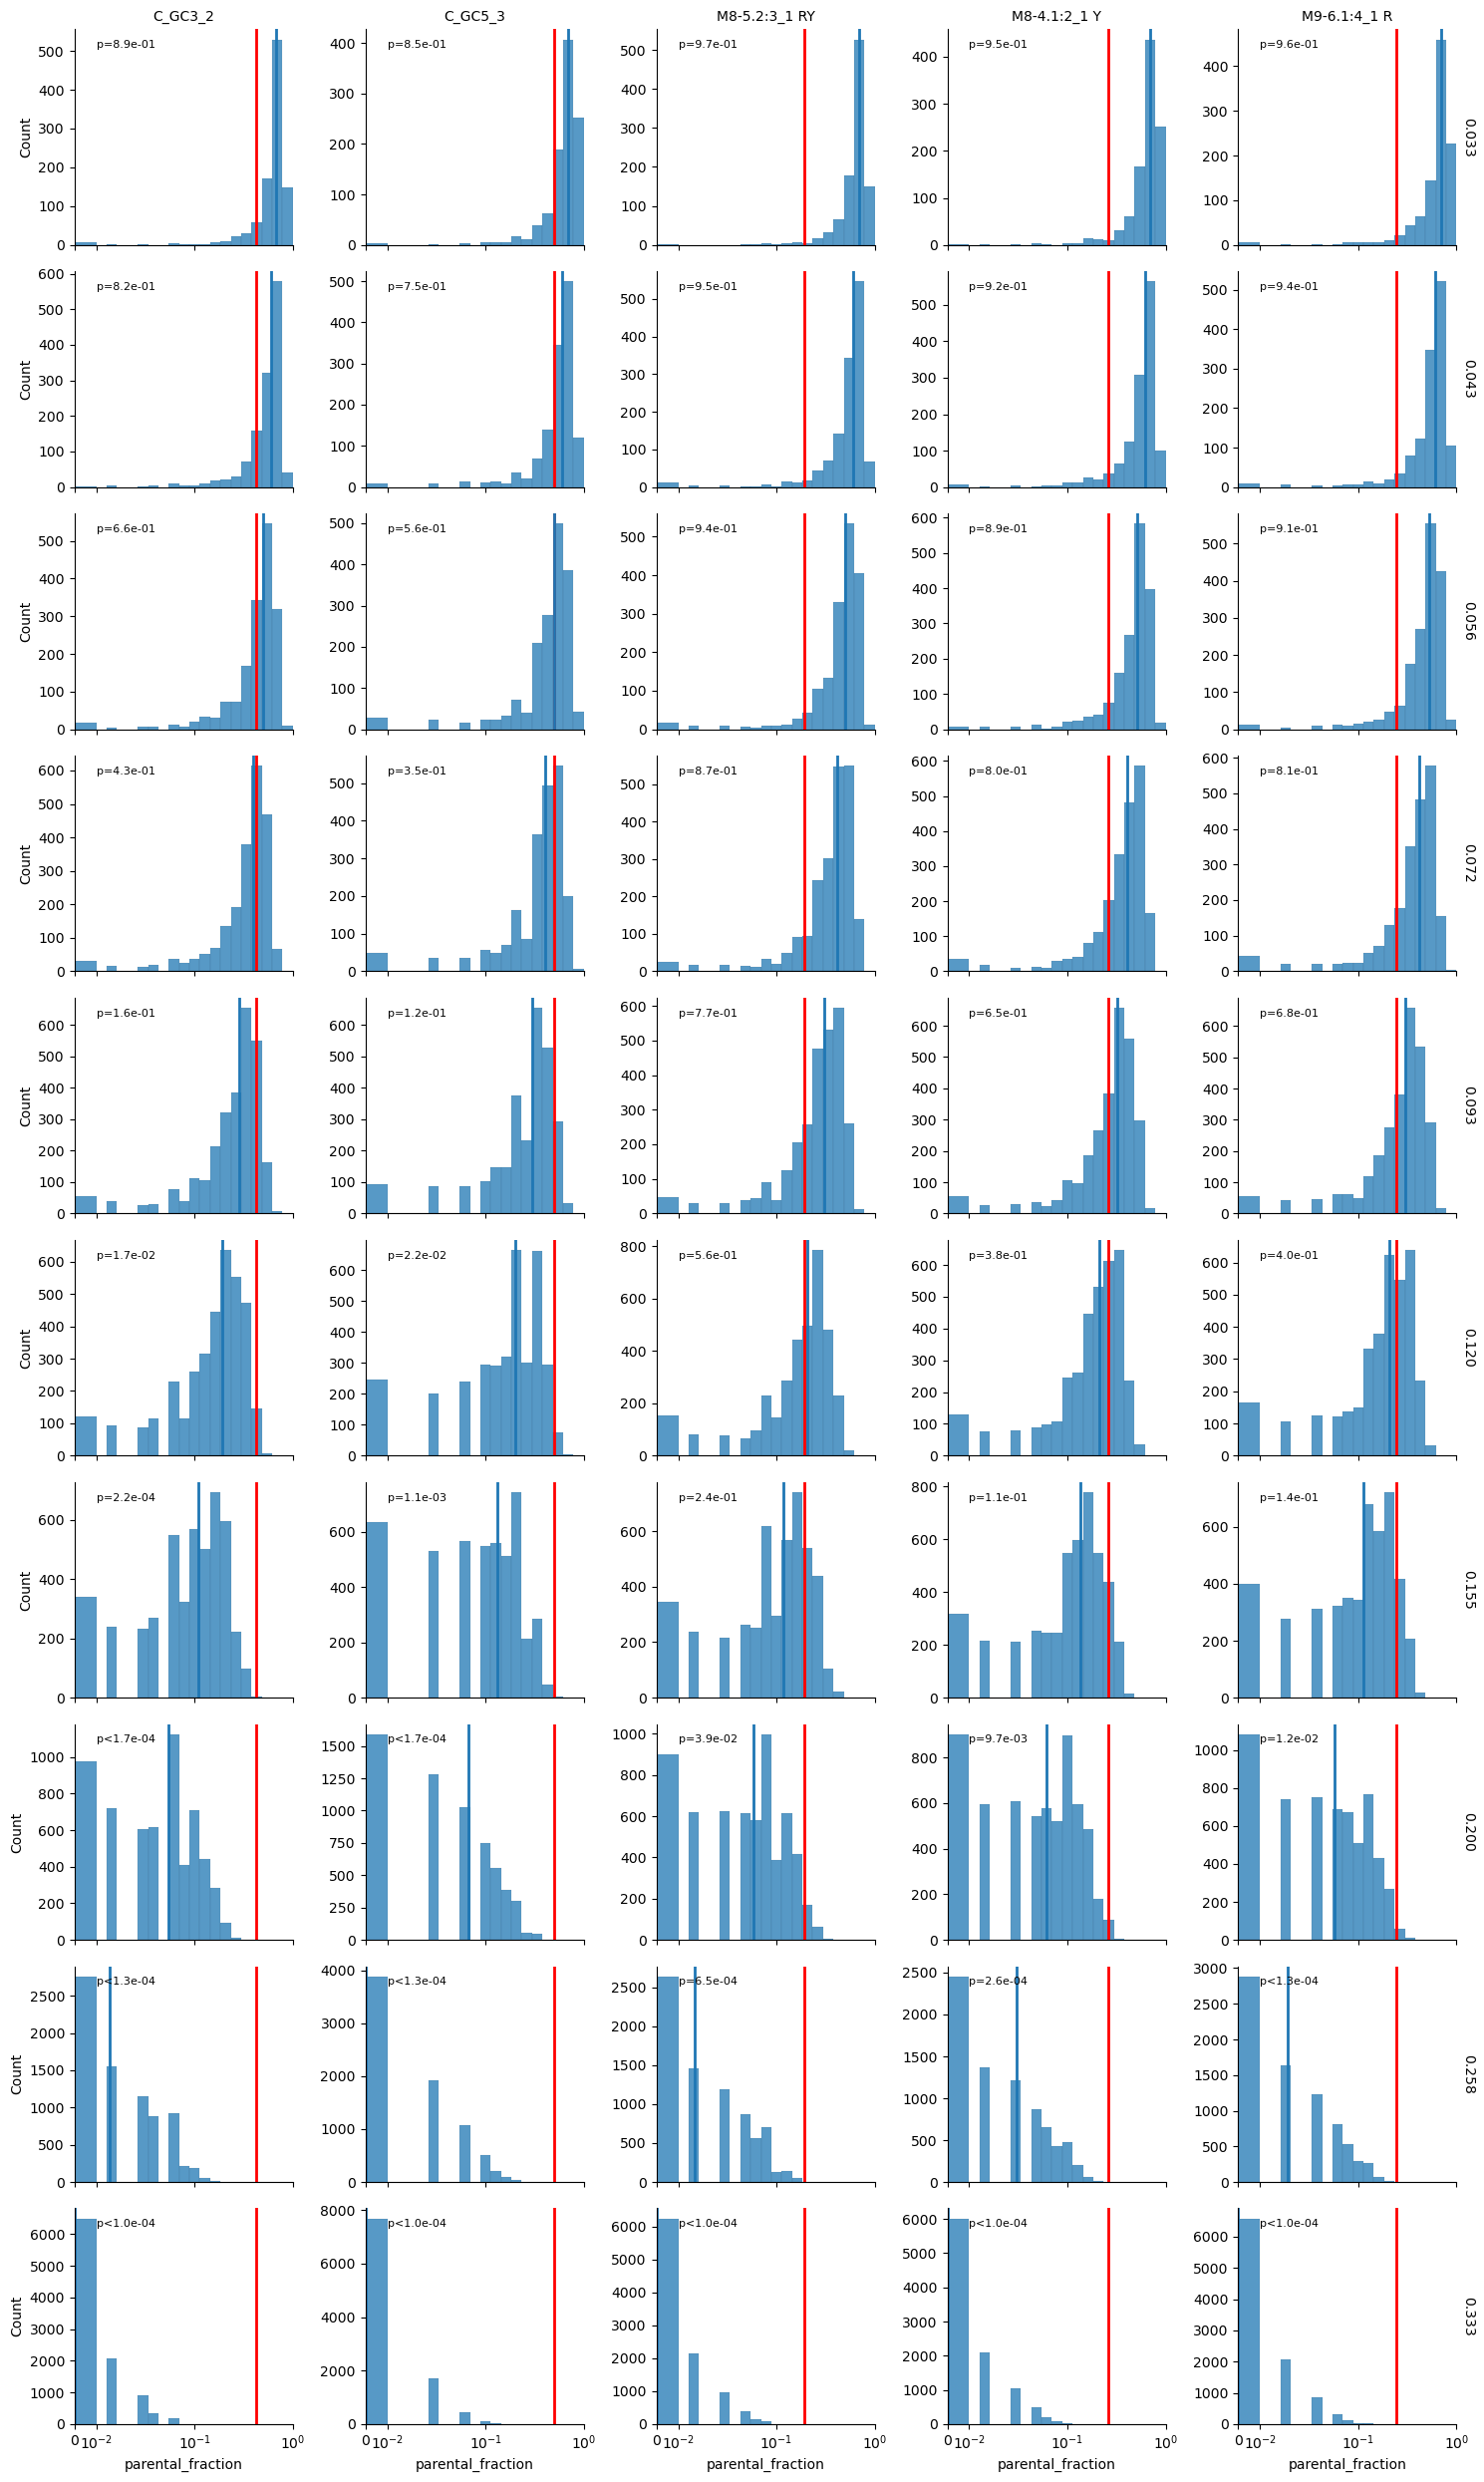

In [62]:
g = sns.displot(data=sim_df, x="parental_fraction", row="mutation_prob", col="GC",
                kind="hist", bins=[0] + list(np.geomspace(.01, 1, 20)), stat="count", common_norm=False,
                height=2.5, aspect=1.2, facet_kws=dict(margin_titles=True, sharex=True, sharey=False))

g.set_titles(col_template="{col_name}", row_template="{row_name:.3f}")

for mutation_prob, n_sim in zip(mutation_probs, n_sims):
    for gc in df.index:
        plt.sca(g.axes_dict[(mutation_prob, gc)])
        plt.xscale("symlog", linthresh=.01, linscale=.2)
        plt.xlim(0, 1)
        n = df.loc[gc, "# total in burst"]
        n_parental_true = df.loc[gc, "# in bursting node"]
        plt.axvline(n_parental_true / n, color="red", lw=2)
        n_parental_median = sim_df.query(f"GC == '{gc}' and mutation_prob == {mutation_prob}").n_parental.median()
        plt.axvline(n_parental_median / n, color="C0", lw=2)
        n_parental_sims = sim_df.query(f"GC == '{gc}' and mutation_prob == {mutation_prob}").n_parental
        p = (n_parental_sims >= n_parental_true).mean()
        if p == 0:
            p = 1 / n_sim
            p_rel = "<"
        else:
            p_rel = "="
        plt.annotate(f"p{p_rel}{p:.1e}",
                    (0.1, 0.95), xycoords="axes fraction", ha="left", va="top",
                    fontsize=8)

g.tight_layout()
plt.savefig(f"output/sim_hist.pdf")
plt.show()

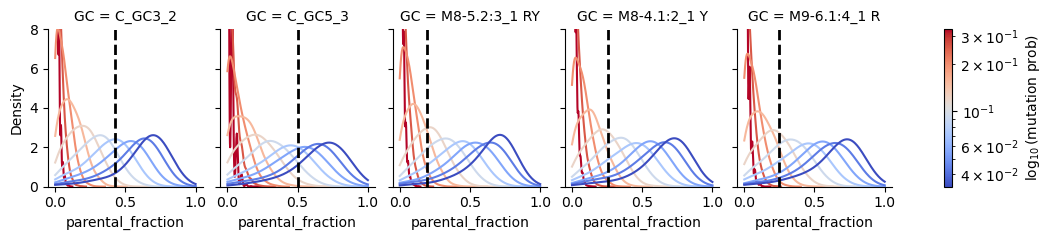

In [267]:
g = sns.displot(data=sim_df, x="parental_fraction", hue=np.log10(sim_df.mutation_prob), col="GC",
                kind="kde", bw_adjust=2., common_norm=False, log_scale=[False, False], clip=(0, 1),
                height=2.5, aspect=0.9, palette="coolwarm", legend=False)
plt.ylim(0, 8)
plt.tight_layout()
# colorbar
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=sim_df.mutation_prob.min(), vmax=sim_df.mutation_prob.max()),
                                          cmap="coolwarm"),
                    ax=g.axes[-1], label=r"$\log_{10}(\text{mutation prob})$",
)
for gc in df.index:
    plt.sca(g.axes_dict[gc])
    n = df.loc[gc, "# total in burst"]
    n_parental_true = df.loc[gc, "# in bursting node"]
    plt.axvline(n_parental_true / n, color="k", ls="--", lw=2)
plt.savefig(f"output/sim_kde.pdf")
plt.show()

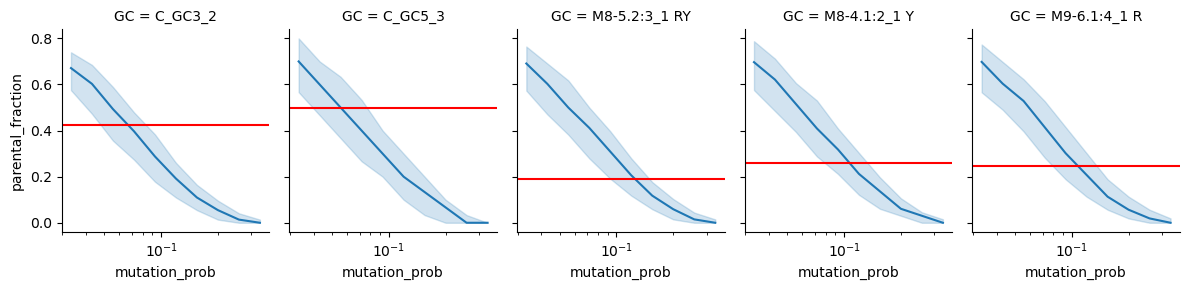

In [57]:
g = sns.relplot(data=sim_df, y="parental_fraction", x="mutation_prob",
                estimator="median", errorbar=('pi', 50), # median and IQR
                col="GC", kind="line",
                height=3, aspect=0.8)
plt.xscale("log")
# plt.yscale("log")
for gc in df.index:
    plt.sca(g.axes_dict[gc])
    plt.axhline(df.loc[gc, "parental fraction"], color="red")
    # plt.xlim(.03, 1)
g.tight_layout()
plt.savefig(f"output/sim_line.pdf")

In [162]:
tmp = sim_df.groupby(["GC", "mutation_prob"]).parental_fraction.median().reset_index()
display(tmp)
tmp["abs_residual"] = (tmp.parental_fraction - df.loc[tmp.GC, "parental fraction"].values).abs()
tmp = tmp.groupby("GC").apply(lambda x: x.loc[x.abs_residual.idxmin()]).reset_index(drop=True)[["GC", "mutation_prob"]]

tmp.to_csv("output/estimate.csv", index=False)
tmp

,GC,mutation_prob,parental_fraction
0,C_GC3_2,0.033333,0.671233
1,C_GC3_2,0.043052,0.602740
2,C_GC3_2,0.055603,0.493151
3,C_GC3_2,0.071814,0.397260
4,C_GC3_2,0.092752,0.287671
5,C_GC3_2,0.119794,0.191781
6,C_GC3_2,0.154720,0.109589
7,C_GC3_2,0.199828,0.054795
8,C_GC3_2,0.258088,0.013699
9,C_GC3_2,0.333333,0.000000


/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_42186/1484331571.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby("GC").apply(lambda x: x.loc[x.abs_residual.idxmin()]).reset_index(drop=True)[["GC", "mutation_prob"]]


,GC,mutation_prob
0,C_GC3_2,0.071814
1,C_GC5_3,0.055603
2,M8-4.1:2_1 Y,0.119794
3,M8-5.2:3_1 RY,0.119794
4,M9-6.1:4_1 R,0.119794


In [ ]:
sim_df_collapsed = sim_df.value_counts().reset_index()
sim_df_collapsed.to_csv(f"output/sim.csv")

sim_df_collapsed